Φορτώνουμε τις βιβλιοθήκες που θα χρειαστούμε.

In [1]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier()
from sklearn.naive_bayes import GaussianNB
gnb=GaussianNB()
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
sc = StandardScaler()
os = SMOTE()
pca = PCA()
xgb = XGBClassifier()
ros=RandomOverSampler()
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import train_test_split
%matplotlib inline
plt.style.use('seaborn')

Διαβάζουμε το dataset.

In [2]:
users = pd.read_csv('train_users_2.csv')

In [3]:
users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


Το baseline πρόβλεψης είναι περίπου 58%, όσο το ποσοστό της μεγαλύτερης κλάσης ('NDF').

In [32]:
users.country_destination.value_counts() / len(users)

NDF      0.583473
US       0.292226
other    0.047290
FR       0.023532
IT       0.013282
GB       0.010888
ES       0.010536
CA       0.006690
DE       0.004971
NL       0.003570
AU       0.002525
PT       0.001017
Name: country_destination, dtype: float64

Text(0, 0.5, 'Percentage of booking')

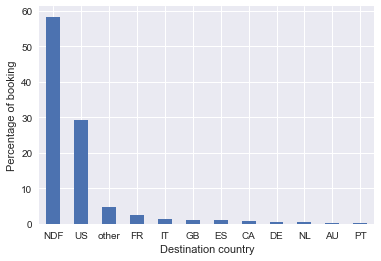

In [6]:
sns.set_style()
des_countries = users.country_destination.value_counts(dropna = False) /users.shape[0] * 100
des_countries.plot('bar', rot = 0)
plt.xlabel('Destination country')
plt.ylabel('Percentage of booking')

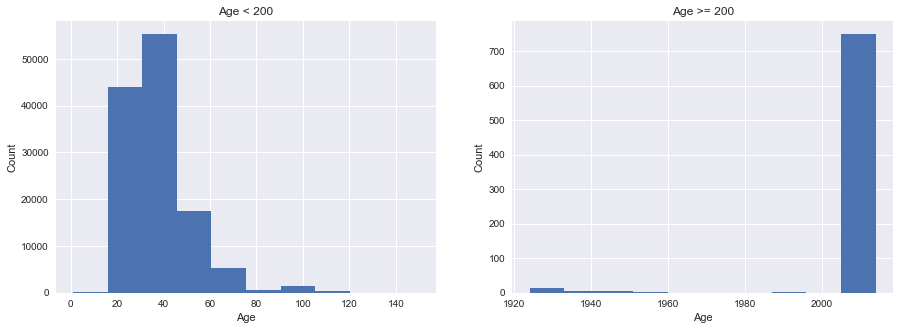

In [8]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))

axes[0].set_title('Age < 200')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Count')
users[users.age < 200].age.hist(bins = 10, ax = axes[0])

axes[1].set_title('Age >= 200')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Count')
users[users.age >= 200].age.hist(bins = 10, ax = axes[1])

In [33]:
#nan τιμές σε κάθε στήλη
users.isnull().sum(axis=0)

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

Διώχνουμε id και date_first_booking. Το πρώτο καθώς δεν θα το χρησιμοποιήσουμε στην ανάλυσή μας και το δεύτερο επειδή δίνει πληροφορία με μεγάλη συσχέτιση με την target variable (αν δεν υπάρχει τιμή date_first_booking δεν υπάρχει και προορισμός ('NDF')). Θέλουμε το μοντέλο να εκπαιδευτεί στις υπόλοιπες μεταβλητές.

In [34]:
users = users.drop(['id', 'date_first_booking'], axis=1)

In [38]:
# αντικαθιστούμε τα nan με 'untracked' στην μεταβλητή 'first_affiliate_tracked' feature
users.loc[users.first_affiliate_tracked.isnull(), 'first_affiliate_tracked'] = 'untracked'

In [39]:
#αντικαθιστούμε την τιμή 'OTHER' με 'unknown'
users.gender= users.gender.replace('OTHER', '-unknown-')

# Χωρίς one hot encoding
Αρχικά δεν θα κάνουμε one hot encoding για να δούμε τα αποτελέσματα που θα μας δώσουν οι ταξινομητές μας. Σημειώνεται ότι ο θεωρητικά καλύτερος (XGBClassifier) επεξεργάζεται τις κλάσεις μόνος του, δηλαδή δουλεύει και χωρίς one hot encoding. Υπάρχει γενικά διχογνωμία στην κοινότητα για το εάν βελτιώνεται ή όχι ο συγκεκριμένος ταξινομητής με one hot encoding. Για αυτό δοκιμάζουμε και τις δύο περιπτώσεις. Ο Random Forest Classifier, ως decision tree, δεν χρειάζεται one hot encoding.

In [47]:
dac = np.vstack(users.date_account_created.astype(str).apply(lambda x:list(map(int,x.split('-')))).values)
users['dac_year'] = dac[:,0]
users['dac_month'] = dac[:,1]
users['dac_day'] = dac[:,2]
users=users.drop(['date_account_created'],axis=1)

tfa = np.vstack(users.timestamp_first_active.astype(str).apply(lambda x:list(map(int,[x[:4],x[4:6],x[6:8],x[8:10],x[10:12],x[12:14]]))).values)
users['tfa_year'] = tfa[:,0]
users['tfa_month'] = tfa[:,1]
users['tfa_day'] = tfa[:,2]
users=users.drop(['timestamp_first_active'],axis=1)

In [54]:
users.loc[users.language == '-unknown-', 'language'] = users.language.mode()[0]
users.language = le.fit_transform(users.language)
users.gender = le.fit_transform(users.gender)
users.signup_app = le.fit_transform(users.signup_app)
users.first_device_type = le.fit_transform(users.first_device_type)
users.first_browser = le.fit_transform(users.first_browser)
users.signup_method = le.fit_transform(users.signup_method)
users.affiliate_channel = le.fit_transform(users.affiliate_channel)
users.affiliate_provider = le.fit_transform(users.affiliate_provider)
users.first_affiliate_tracked = le.fit_transform(users.first_affiliate_tracked)

C:\Users\Fotis\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [55]:
lab_old=pd.DataFrame(users['country_destination'])
feat_old=pd.DataFrame(users.drop(['country_destination'],axis=1))

In [56]:
train_old,test_old,train_lab,test_lab=train_test_split(feat_old,lab_old,test_size=0.33,random_state=6)

In [57]:
train_old=pd.DataFrame(train_old)
test_old=pd.DataFrame(test_old)
train_old.columns=feat_old.columns
test_old.columns=feat_old.columns

In [58]:
train_old.loc[train_old.age > 90, 'age'] = np.nan
train_old.loc[train_old.age < 16, 'age'] = np.nan
med=train_old.age.median()
test_old.loc[test_old.age > 90, 'age'] = np.nan
test_old.loc[test_old.age < 16, 'age'] = np.nan
train_old['age']=train_old['age'].fillna(med)
test_old['age']=test_old['age'].fillna(med)
feat_old.loc[feat_old.age > 90, 'age'] = np.nan
feat_old.loc[feat_old.age < 16, 'age'] = np.nan
feat_old['age']=feat_old['age'].fillna(med)

In [59]:
rfc.fit(train_old,train_lab)
knn.fit(train_old,train_lab)
gnb.fit(train_old,train_lab)
xgb.fit(train_old,train_lab)

C:\Users\Fotis\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.
C:\Users\Fotis\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
C:\Users\Fotis\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Fotis\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [62]:
print(' Random Forest :',rfc.score(test_old,test_lab),
     '\n KNN :',knn.score(test_old,test_lab),
     '\n Gaussian Naive Bayes :',gnb.score(test_old,test_lab),
     '\n XGBoost :',xgb.score(test_old,test_lab))

 Random Forest : 0.5726231207143769 
 KNN : 0.5645310126492427 
 Gaussian Naive Bayes : 0.5386078734791806 
 XGBoost : 0.6330158009057483


Παρατηρούμε ότι ο καλύτερος ταξινομητής στο αρχικό dataset είναι ο XGBoost. Αυτό είναι κάτι που περιμέναμε καθώς είναι ο state of the art σε τέτοια προβλήματα. Ωστόσο οι τιμές του score δεν είναι ικανοποιητικές, μόλις 5% πάνω από το baseline. Για αυτό θα χρησιμοποιήσουμε over sampling. Θα περιοριστούμε μόνο στους Random Forest και XGBoost, λόγω του ότι είχαν το καλύτερο score αρχικά.

In [63]:
features,labels=ros.fit_resample(feat_old,lab_old.values.ravel())

In [64]:
train_users,test_users,train_labels,test_labels=train_test_split(features,labels,test_size=0.33,random_state=5)

In [65]:
rfc.fit(train_users,train_labels)
xgb.fit(train_users,train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [67]:
print(' Random Forest :',rfc.score(test_old.values,test_lab),
     '\n XGBoost :',xgb.score(test_old.values,test_lab))

 Random Forest : 0.8278794417865103 
 XGBoost : 0.3453768508922614


Ο Random Over Sampler δεν συνδυάζεται σωστά με τον XGBoost, κάτι που φαίνεται στο αποτέλεσμα. Ωστόσο, ο Random Forest συνδυάζεται πολύ καλά (το είδαμε και στο dataset του μαθήματος Εξόρυξη γνώσης από Δεδομένα) και βγάζει ικανοποιητικό score (όχι για submission στο Kaggle, αυτό θα γινόταν μόνο με hyper parameter tuning του XGBoost). Ο confusion matrix δείχνει πολύ καλή προβλεπτική ικανότητα σε όλες τις κλάσεις. Η καμπύλη μάθησης δείχνει ότι χρειαζόταν αρκετά δεδομένα (περίπου 300000, που προέκυψαν από τον over sampler) για να αρχίσει να συγκλίνει προς το τελικό αποτέλεσμα (δείχνει score κοντά στο 90% γιατί η καμπύλη αφορά τα δεδομένα του over sampled dataset. Στα πραγματικά έχει score περίπου 83%).

In [73]:
def plot_confusion_matrix(y_true, y_pred,classes, 
                          normalize,
                          title=None,
                          cmap=plt.cm.Blues):
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[  197     0     0     0     0     0     0     0     0     0     0     0]
 [    0   486     1     0     0     0     0     0     1     1     0     0]
 [    0     1   336     0     0     0     0     0     1     0     0     0]
 [    0     2     0   734     0     0     0     0     1     0     0     0]
 [    0     5     0     6  1621     4     9     1     4     0     0     2]
 [    1     1     2     1     0   746     1     0     1     1     0     0]
 [    2     5     3     6     1     3   886     0     1     1     0     0]
 [   67   267   182   382   775   450   574 32451   124    35  4293  1406]
 [    0     0     0     0     0     0     0     0   237     0     0     0]
 [    0     0     0     0     0     0     0     0     0    81     0     0]
 [   23    61    39   121   208   121   147  2220    44     8 17422   370]
 [    0    12     9    19    25    17    18    24     7     2     5  3118]]


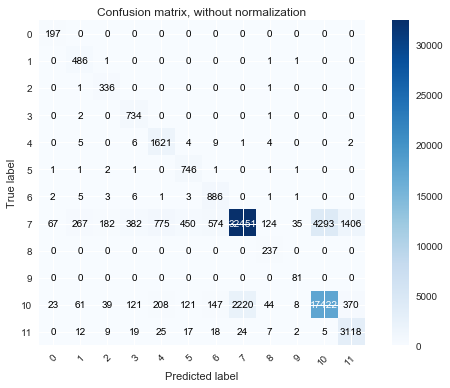

In [74]:
cls=list(range(12))
plot_confusion_matrix(test_lab,rfc.predict(test_old.values),cls,normalize=0)

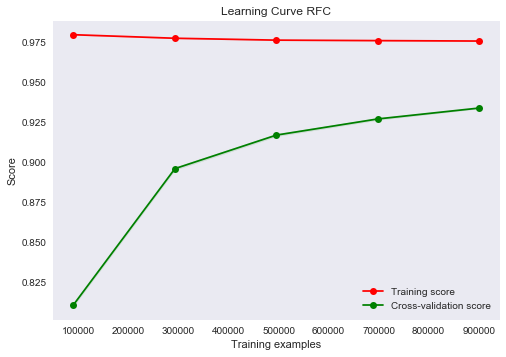

In [75]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):


    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt




title = r"Learning Curve RFC"
estimator = rfc
plot_learning_curve(estimator, title, train_users, train_labels, cv=10, n_jobs=4)

plt.show()

# Με one hot encoding
Εξετάζουμε τώρα τα αποτελέσματα με one hot encoding.

In [76]:
users = pd.read_csv('train_users_2.csv')

In [77]:
users = users.drop(['id', 'date_first_booking'], axis=1)

In [78]:
#feature enginering
dac = np.vstack(users.date_account_created.astype(str).apply(lambda x:list(map(int,x.split('-')))).values)
users['dac_year'] = dac[:,0]
users['dac_month'] = dac[:,1]
users['dac_day'] = dac[:,2]
users=users.drop(['date_account_created'],axis=1)

tfa = np.vstack(users.timestamp_first_active.astype(str).apply(lambda x:list(map(int,[x[:4],x[4:6],x[6:8],x[8:10],x[10:12],x[12:14]]))).values)
users['tfa_year'] = tfa[:,0]
users['tfa_month'] = tfa[:,1]
users['tfa_day'] = tfa[:,2]
users=users.drop(['timestamp_first_active'],axis=1)

In [79]:
train_variance = X_train.var(axis=0)
print(train_variance)
print(np.max(train_variance))

age                                   76.933835
dac_year                               0.879412
dac_month                             10.487830
dac_day                               76.485432
tfa_year                               0.880563
tfa_month                             10.486029
tfa_day                               76.477881
gender_-unknown-                       0.247432
gender_FEMALE                          0.208015
gender_MALE                            0.190267
signup_method_basic                    0.202847
signup_method_facebook                 0.201668
signup_method_google                   0.002692
signup_flow_0                          0.176538
signup_flow_1                          0.004802
signup_flow_2                          0.030771
signup_flow_3                          0.040054
signup_flow_4                          0.000007
signup_flow_5                          0.000140
signup_flow_6                          0.001459
signup_flow_8                          0

In [80]:
#One-hot-encoding features
ohe_feats = ['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 
             'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
for f in ohe_feats:
    users_dummy = pd.get_dummies(users[f], prefix=f)
    users = users.drop([f], axis=1)
    users = pd.concat((users, users_dummy), axis=1)

In [81]:
labels = users.country_destination
users = users.drop(['country_destination'], axis=1)

le = LabelEncoder()
labels_transformed = le.fit_transform(labels)

In [82]:
#Splitting train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(users, labels_transformed, test_size=0.33, random_state=123)

In [83]:
#Process την μεταβλητή "age".
X_train.loc[X_train.age > 90, 'age'] = np.nan
X_train.loc[X_train.age < 16, 'age'] = np.nan
X_test.loc[X_test.age > 90, 'age'] = np.nan
X_test.loc[X_test.age < 16, 'age'] = np.nan

med = X_train.age.median()

X_train['age'] = X_train['age'].fillna(med)
X_test['age'] = X_test['age'].fillna(med)

C:\Users\Fotis\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\Fotis\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Fotis\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

To Gridsearch δεν μπόρεσε να τρέξει για όλο τον συνδυασμό παραμέτρων που χρειαζόμασταν (ξεπερνούσε το runtime του Colab με GPU runtime type). Τρέχοντάς το μόνο με SMOTE και PCA φαίνεται το classification report, που δεν είναι καθόλου ικανοποιητικό ούτε για τον Random Forest ούτε για τον XGBoost.

In [17]:
# φέρνουμε τις γνωστές μας κλάσεις για preprocessing


# αρχικοποιούμε τους εκτιμητές (μετασχηματιστές και ταξινομητή) χωρίς παραμέτρους

vt = VarianceThreshold()
sc = StandardScaler()
os = SMOTE()
pca = PCA()
rf = RandomForestClassifier()


pipe = Pipeline([
    ('scaler', sc),
    ('sampler', os),
    ('pca', pca),
    ('classifier', rf)
])

params = {'pca__n_components': [10, 50, 90, 110]}
          'classifier__n_estimators': [100, 101, 102], 
          'classifier__max_depth': [4, 6, 8, 10]}

#βελτιστοποίηση υπερπαραμέτρων για το random forest classifier
grid = GridSearchCV(pipe, params, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  12 | elapsed: 10.4min remaining: 51.9min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 14.0min finished
C:\Users\Fotis\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Fotis\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Fotis\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sampler', SMOTE(k_neighbors=5, kind='deprecated', m_neighbors='deprecated', n_jobs=1,
   out_step='deprecated', random_state=None, ratio=None,
   sampling_strategy='auto', svm_estimator='deprecated')), ('pca', PCA(copy=Tr...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'pca__n_components': [10, 50, 90, 110]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=1)

In [25]:
#εκτιμήσεις για το random forest classifier
preds = grid.predict(X_test)
from sklearn.metrics  import classification_report
from sklearn.metrics  import accuracy_score
print(classification_report(y_test, preds))
print(accuracy_score(y_test, preds))

C:\Users\Fotis\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


              precision    recall  f1-score   support

           0       0.01      0.02      0.01       185
           1       0.01      0.04      0.02       469
           2       0.01      0.02      0.01       368
           3       0.01      0.04      0.02       737
           4       0.04      0.09      0.05      1740
           5       0.02      0.06      0.03       764
           6       0.02      0.06      0.03       947
           7       0.69      0.55      0.61     41030
           8       0.01      0.03      0.02       253
           9       0.00      0.00      0.00        72
          10       0.38      0.30      0.34     20506
          11       0.06      0.09      0.07      3368

   micro avg       0.42      0.42      0.42     70439
   macro avg       0.10      0.11      0.10     70439
weighted avg       0.51      0.42      0.46     70439

0.41883047743437585


In [19]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
sc = StandardScaler()
os = SMOTE()
pca = PCA()
xgb = XGBClassifier()

pipe_xgb = Pipeline([
    ('scaler', sc),
    ('sampler', os),
    ('pca', pca),
    ('classifier', xgb)
])

params_xgb = {'pca__n_components': [10, 50, 90]}
              #'tree_method': ['gpu_hist']} 
              #'xgbrg__learning_rate': [0.1, 0.5, 1]}

#βελτιστοποίηση υπερπαραμέτρων για το random forest classifier
grid_xgb = GridSearchCV(pipe_xgb, params_xgb, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed: 117.9min remaining: 59.0min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 172.4min finished
C:\Users\Fotis\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Fotis\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sampler', SMOTE(k_neighbors=5, kind='deprecated', m_neighbors='deprecated', n_jobs=1,
   out_step='deprecated', random_state=None, ratio=None,
   sampling_strategy='auto', svm_estimator='deprecated')), ('pca', PCA(copy=Tr...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'pca__n_components': [10, 50, 90]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=1)

In [24]:
#εκτιμήσεις για τον xgboost classifier
preds_xgb = grid_xgb.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, preds_xgb))

C:\Users\Fotis\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


              precision    recall  f1-score   support

           0       0.00      0.15      0.01       185
           1       0.01      0.07      0.01       469
           2       0.01      0.13      0.02       368
           3       0.02      0.10      0.03       737
           4       0.04      0.08      0.05      1740
           5       0.02      0.05      0.02       764
           6       0.02      0.10      0.04       947
           7       0.75      0.39      0.52     41030
           8       0.00      0.09      0.01       253
           9       0.00      0.07      0.00        72
          10       0.41      0.07      0.12     20506
          11       0.06      0.06      0.06      3368

   micro avg       0.26      0.26      0.26     70439
   macro avg       0.11      0.11      0.07     70439
weighted avg       0.56      0.26      0.34     70439



In [37]:
xgb.fit(X_train, y_train)
y_pred_3 = xgb.predict(X_test) 

In [38]:
print(confusion_matrix(y_test,y_pred_3))

[[    0     0     0     0     0     0     0   103     0     0    82     0]
 [    0     0     0     0     0     0     0   252     0     0   217     0]
 [    0     0     0     0     0     0     0   212     0     0   156     0]
 [    0     0     0     0     0     0     0   465     0     0   272     0]
 [    0     0     0     0     0     0     0  1027     0     0   713     0]
 [    0     0     0     0     0     0     0   459     0     0   305     0]
 [    0     0     0     0     0     0     0   572     0     0   375     0]
 [    0     0     0     0     0     0     0 35728     0     0  5302     0]
 [    0     0     0     0     0     0     0   145     0     0   108     0]
 [    0     0     0     0     0     0     0    48     0     0    24     0]
 [    0     0     0     0     0     0     0 12017     0     0  8489     0]
 [    0     0     0     0     0     0     0  2029     0     0  1339     0]]


In [18]:
train,lab=ros.fit_resample(X_train,y_train)

Εφόσον το one hot encoding με PCA και SMOTE έβγαλε τέτοια αποτελέσματα, καταλήγουμε στο ότι δεν ήταν τα κατάλληλα για το πρόβλημά μας. Με περισσότερους πόρους θα κάναμε hyper parameter tuning στον XGBoost, από όπου φαίνεται πως έχουν παρθεί τα καλύτερα αποτελέσματα από το leaderboard του διαγωνισμού. Η καλύτερη δική μας προσπάθεια ήταν χωρίς one hot encoding, με Random Forest και Random Over Sampler. Φαίνεται ότι το one hot encoding κάνει περισσότερο κακό παρά καλό στα decision trees.